#### Acknowledgement
In this notebook, GPT-4o is used to help debug code and prettify visualisations.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import seaborn as sns

import contextily as ctx
from shapely.geometry import MultiPoint, Point, MultiLineString, LineString, MultiPolygon, Polygon

In [2]:
from sklearn.model_selection import train_test_split

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

from scipy.interpolate import NearestNDInterpolator

from affine import Affine

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import rasterio as rio

from scipy.spatial import cKDTree

# WGMS

## 1. GLACIER
General (and presumably static) information about each glacier

In [3]:
glacier = pd.read_csv("data/wgms/glacier.csv")

glacier_nz = glacier[glacier["POLITICAL_UNIT"] == "NZ"]

glacier_nz_drop = glacier_nz.drop(["POLITICAL_UNIT", "REMARKS", "GLACIER_REGION_CODE", "GLACIER_SUBREGION_CODE",
                                  "GEN_LOCATION", "SPEC_LOCATION", "PARENT_GLACIER",
                                  "PRIM_CLASSIFIC", "FORM", "FRONTAL_CHARS", "EXPOS_ACC_AREA", "EXPOS_ABL_AREA"], axis=1)
glacier_nz_drop.head()

C:\Users\Zach\AppData\Local\Temp\ipykernel_12264\3864064715.py:1: DtypeWarning: Columns (3,4,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  glacier = pd.read_csv("data/wgms/glacier.csv")


,NAME,WGMS_ID,LATITUDE,LONGITUDE
158448,ABEL,1546,-43.320000,170.630005
158449,ADAMS,2923,-43.320000,170.720001
158450,AILSA,2924,-44.786100,168.187000
158451,ALMER/SALISBURY,1548,-43.470001,170.220001
158452,ANDY,1590,-44.430000,168.369995


In [4]:
glacier_nz_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2869 entries, 158448 to 161316
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       2869 non-null   object 
 1   WGMS_ID    2869 non-null   int64  
 2   LATITUDE   2869 non-null   float64
 3   LONGITUDE  2869 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 112.1+ KB


## 2. CHANGE
Change in glacier thickness, area, and/or volume – typically from geodetic surveys



In [5]:
change = pd.read_csv("data/wgms/change.csv")

change_nz = change[change["POLITICAL_UNIT"] == "NZ"]

change_nz_drop = change_nz.drop(["POLITICAL_UNIT",
                                 "NAME",
                                 "SURVEY_ID",
                                 "SURVEY_DATE",
                                 "REFERENCE_DATE",
                                 "LOWER_BOUND",
                                 "UPPER_BOUND",
                                 "AREA_CHANGE",  # all NaN
                                 "AREA_CHANGE_UNC",
                                 "AREA_SURVEY_YEAR",
                                 "THICKNESS_CHG_UNC",
                                 "VOLUME_CHANGE_UNC",
                                 "SD_PLATFORM_METHOD",
                                 "RD_PLATFORM_METHOD",
                                 "INVESTIGATOR",
                                 "SPONS_AGENCY",
                                 "REFERENCE",
                                 "REMARKS"], axis=1)
change_nz_drop.rename(columns = {'YEAR':'CHANGE_YEAR'}, inplace = True)
change_nz_drop.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHG,VOLUME_CHANGE
814867,2923,2013,5913.0,NaN
814868,2923,2018,-14433.0,NaN
814869,2923,2018,-13184.0,NaN
814870,2923,2014,-7845.0,NaN
814871,2923,2017,-7478.0,NaN


In [6]:
change_nz_drop["CHANGE_YEAR"].value_counts()

CHANGE_YEAR
2017    6998
2015    6584
2014    6162
2016    5848
2019    5516
2012    3764
2013    3107
2009    2853
2004    2758
2018     940
2011     720
2010     393
Name: count, dtype: int64

In [7]:
change_nz_drop[change_nz_drop['CHANGE_YEAR'] == 2009]["WGMS_ID"].nunique()

2767

In [8]:
change_nz_drop[change_nz_drop['CHANGE_YEAR'] == 2019]["WGMS_ID"].nunique()

2758

## 3. Merge WGMS
change and glacier

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
merge_1 = pd.merge(change_nz_drop, glacier_nz_drop, how="left", on="WGMS_ID").drop("VOLUME_CHANGE", axis=1)
merge_1.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHG,NAME,LATITUDE,LONGITUDE
0,2923,2013,5913.0,ADAMS,-43.32,170.720001
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001


In [11]:
merge_1.rename(columns={'THICKNESS_CHG': 'THICKNESS_CHANGE'}, inplace=True)

In [12]:
gdf_wgms = (
    gpd.GeoDataFrame(
        merge_1, geometry=gpd.points_from_xy(merge_1.LONGITUDE, merge_1.LATITUDE), crs="EPSG:4326"
    )
)

gdf_wgms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45643 entries, 0 to 45642
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   WGMS_ID           45643 non-null  int64   
 1   CHANGE_YEAR       45643 non-null  int64   
 2   THICKNESS_CHANGE  45643 non-null  float64 
 3   NAME              45643 non-null  object  
 4   LATITUDE          45643 non-null  float64 
 5   LONGITUDE         45643 non-null  float64 
 6   geometry          45643 non-null  geometry
dtypes: float64(3), geometry(1), int64(2), object(1)
memory usage: 2.4+ MB


In [13]:
gdf_wgms.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)


####

In [14]:
# Step 1: Find the top 5 glaciers with the most records
wgms_count_top5 = gdf_wgms.groupby('WGMS_ID').size().reset_index(name='count').nlargest(5, 'count')

# Step 2: Extract the top 5 glaciers and sum thickness change by year
top_5_glaciers = gdf_wgms[gdf_wgms['WGMS_ID'].isin(wgms_count_top5['WGMS_ID'])]

# Step 3: Group by WGMS_ID and CHANGE_YEAR to calculate yearly thickness change
gdf_top5_yr_tk_cng = top_5_glaciers.groupby(['WGMS_ID', 'CHANGE_YEAR'])['THICKNESS_CHANGE'].sum().reset_index()

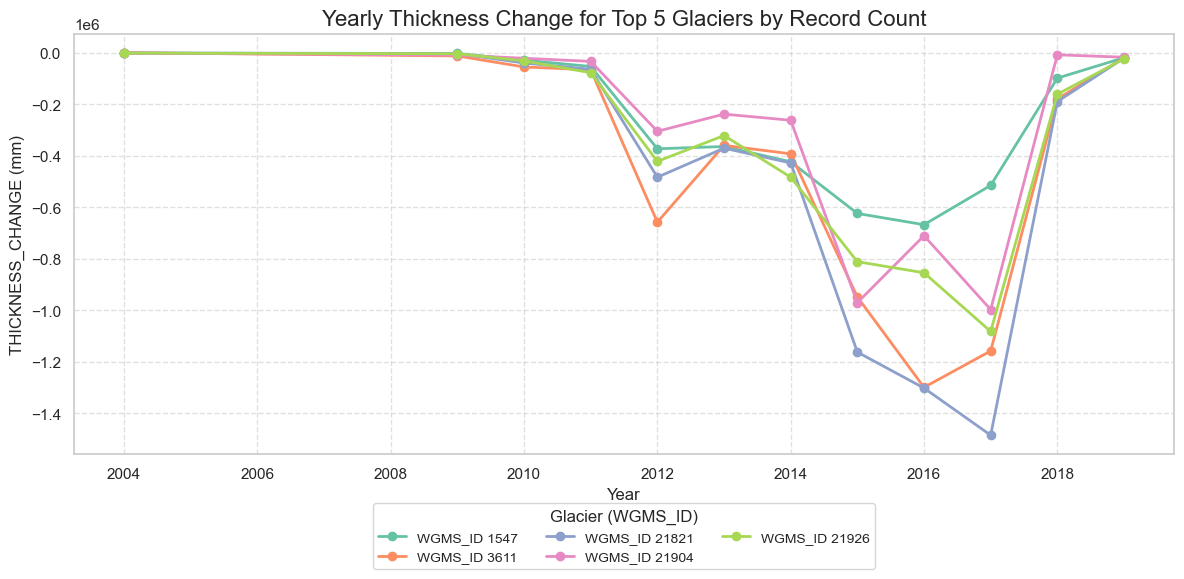

In [15]:
# Use Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Colors for Top 5 glaciers
colors = sns.color_palette("Set2", 5)

# Plot each glacier's thickness change
for i, wgms_id in enumerate(gdf_top5_yr_tk_cng['WGMS_ID'].unique()):
    glacier_data = gdf_top5_yr_tk_cng[gdf_top5_yr_tk_cng['WGMS_ID'] == wgms_id]
    plt.plot(glacier_data['CHANGE_YEAR'], glacier_data['THICKNESS_CHANGE'], 
             marker='o', linestyle='-', color=colors[i], label=f'WGMS_ID {wgms_id}', linewidth=2)

plt.title('Yearly Thickness Change for Top 5 Glaciers by Record Count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('THICKNESS_CHANGE (mm)', fontsize=12)

plt.legend(title='Glacier (WGMS_ID)', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

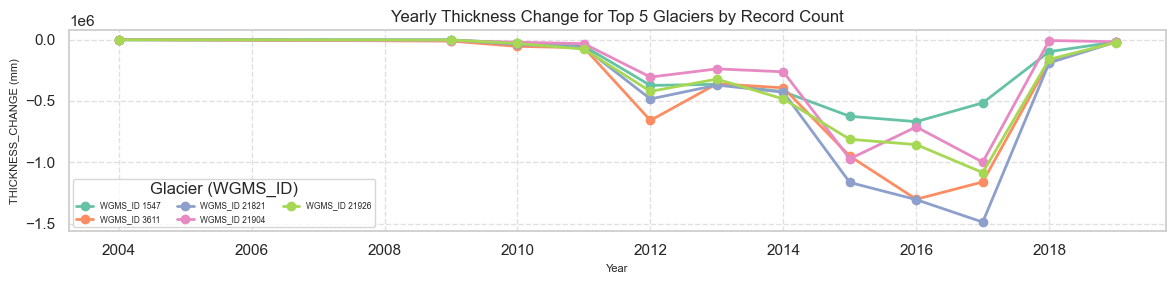

In [16]:
# Use Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 3))

# Colors for Top 5 glaciers
colors = sns.color_palette("Set2", 5)

# Plot each glacier's thickness change
for i, wgms_id in enumerate(gdf_top5_yr_tk_cng['WGMS_ID'].unique()):
    glacier_data = gdf_top5_yr_tk_cng[gdf_top5_yr_tk_cng['WGMS_ID'] == wgms_id]
    plt.plot(glacier_data['CHANGE_YEAR'], glacier_data['THICKNESS_CHANGE'], 
             marker='o', linestyle='-', color=colors[i], label=f'WGMS_ID {wgms_id}', linewidth=2)

plt.title('Yearly Thickness Change for Top 5 Glaciers by Record Count', fontsize=12)
plt.xlabel('Year', fontsize=8)
plt.ylabel('THICKNESS_CHANGE (mm)', fontsize=8)

plt.legend(title='Glacier (WGMS_ID)', loc='lower left', ncol=3, fontsize=6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Examine the glacier in ALL

In [17]:
# NZ TA
# https://datafinder.stats.govt.nz/layer/111193-territorial-authority-2023-clipped-generalised/

ta = gpd.read_file("data/nz_ta/territorial-authority-2023-clipped-generalised.shp").to_crs(4326)
ta

,TA2023_V1_,TA2023_V_1,TA2023_V_2,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
0,001,Far North District,Far North District,6686.609620,6698.957440,2.167300e+06,"MULTIPOLYGON (((173.48 -35.387, 173.48 -35.387..."
1,002,Whangarei District,Whangarei District,2711.440261,2711.440261,9.264072e+05,"MULTIPOLYGON (((174.7 -35.992, 174.7 -35.992, ..."
2,003,Kaipara District,Kaipara District,3109.089171,3109.089171,9.343111e+05,"MULTIPOLYGON (((174.27 -36.289, 174.27 -36.289..."
3,011,Thames-Coromandel District,Thames-Coromandel District,2207.590078,2207.590078,8.337440e+05,"MULTIPOLYGON (((175.9 -37.221, 175.9 -37.221, ..."
4,012,Hauraki District,Hauraki District,1270.117050,1270.117050,3.112583e+05,"MULTIPOLYGON (((175.53 -37.169, 175.53 -37.169..."
...,...,...,...,...,...,...,...
62,073,Southland District,Southland District,29575.188900,30226.490278,4.022673e+06,"MULTIPOLYGON (((167.5 -47.288, 167.5 -47.288, ..."
63,074,Gore District,Gore District,1253.848352,1253.848352,2.345176e+05,"POLYGON ((169 -45.792, 169 -45.793, 169 -45.79..."
64,075,Invercargill City,Invercargill City,389.917666,389.917666,2.689775e+05,"MULTIPOLYGON (((168.41 -46.649, 168.41 -46.649..."
65,076,Auckland,Auckland,4941.164248,4942.230520,2.894126e+06,"MULTIPOLYGON (((174.78 -36.957, 174.78 -36.957..."


In [18]:
# ta.explore()

In [19]:
# Spatial join depends on ta
gdf_joined = gpd.sjoin(gdf_wgms, ta, how="inner", predicate="within")

In [20]:
gdf_joined.head(5)

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry,index_right,TA2023_V1_,TA2023_V_1,TA2023_V_2,LAND_AREA_,AREA_SQ_KM,Shape_Leng
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033


In [21]:
# Aggregate by ta
gpd_tmp1 = gdf_joined.groupby('TA2023_V_1').agg({
    'THICKNESS_CHANGE': 'sum',
    'WGMS_ID': pd.Series.nunique,
    'geometry': lambda x: MultiPoint(list(x))
}).reset_index()

gdf_tmp2 = gpd.GeoDataFrame(gpd_tmp1, geometry='geometry', crs="EPSG:4326")
gdf_tmp2

,TA2023_V_1,THICKNESS_CHANGE,WGMS_ID,geometry
0,Ashburton District,-8808297.0,300,"MULTIPOINT (170.72 -43.32, 170.72 -43.32, 170...."
1,Hurunui District,-79445.0,1,"MULTIPOINT (172.59 -42.22, 172.59 -42.22, 172...."
2,Mackenzie District,-96239089.0,404,"MULTIPOINT (170.42 -43.5, 170.42 -43.5, 170.42..."
3,Queenstown-Lakes District,-40518983.0,527,"MULTIPOINT (168.19 -44.786, 168.19 -44.786, 16..."
4,Ruapehu District,-2560194.0,10,"MULTIPOINT (175.55 -39.275, 175.55 -39.275, 17..."
5,Selwyn District,-1718533.0,152,"MULTIPOINT (171.19 -43.16, 171.19 -43.16, 171...."
6,Southland District,-11174179.0,295,"MULTIPOINT (168.36 -44.42, 168.36 -44.42, 168...."
7,Taupo District,-919008.0,7,"MULTIPOINT (175.57 -39.26, 175.57 -39.26, 175...."
8,Timaru District,-1995411.0,8,"MULTIPOINT (170.62 -43.48, 170.62 -43.48, 170...."
9,Waitaki District,-17982705.0,128,"MULTIPOINT (169.68 -44.076, 169.68 -44.076, 16..."


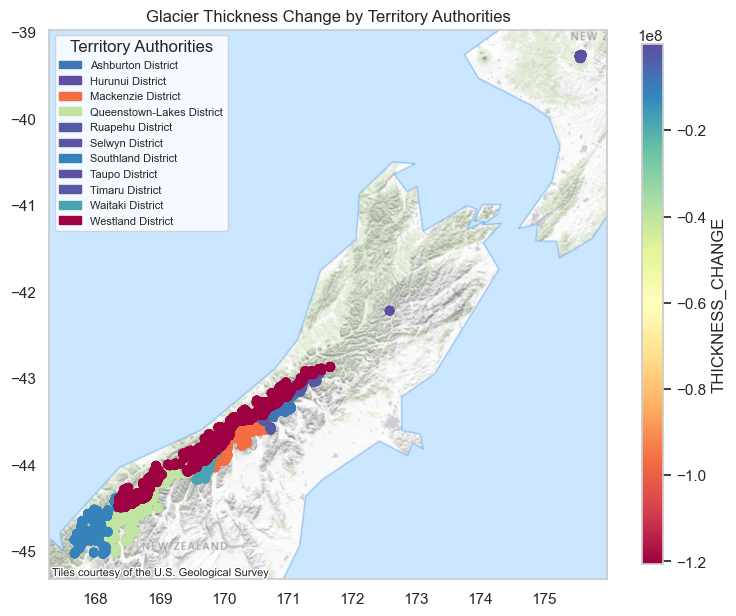

In [22]:
fig, ax = plt.subplots(figsize=(9, 9))
plot = gdf_tmp2.plot(column='THICKNESS_CHANGE', cmap='Spectral', ax=ax)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
cbar.set_label('THICKNESS_CHANGE', size=12)

# Create a custom legend with TA2023_V_1 names and colors
ta_labels = gdf_tmp2['TA2023_V_1'].unique()
# Normalize thickness change values for colors
norm = plt.Normalize(vmin=gdf_tmp2['THICKNESS_CHANGE'].min(), vmax=gdf_tmp2['THICKNESS_CHANGE'].max())
colors = plt.cm.Spectral(norm(gdf_tmp2['THICKNESS_CHANGE']))

# Create legend patches
legend_patches = [Patch(color=color, label=label) for label, color in zip(ta_labels, colors)]

# Add the custom legend to the plot
plt.legend(handles=legend_patches, title='Territory Authorities', loc='upper left', fontsize=8)

plt.grid()
plt.title('Glacier Thickness Change by Territory Authorities')
plt.show()

In [23]:
# gdf_wgms.to_csv("gdf_wgms.csv")

In [24]:
gdf_wgms

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
...,...,...,...,...,...,...,...
45638,1593,2004,-800.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45639,1593,2019,-10840.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45640,1593,2009,-2355.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45641,1593,2014,-3145.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)


In [25]:
gdf_wgms['CHANGE_YEAR'].value_counts(sort=False)

CHANGE_YEAR
2013    3107
2018     940
2014    6162
2017    6998
2015    6584
2016    5848
2004    2758
2019    5516
2009    2853
2012    3764
2010     393
2011     720
Name: count, dtype: int64

### 2009， 2016， 2019

In [26]:
# gdf_wgms_2009 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2009]
# len(gdf_wgms_2009)

2853

In [27]:
# gdf_wgms_2016 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2016]
# len(gdf_wgms_2016)

5848

In [28]:
# gdf_wgms_2019 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2019]
# len(gdf_wgms_2019)

5516

In [29]:
# gdf_wgms_2009.to_file("data_cleaned\gdf_wgms_2009.gpkg")
# gdf_wgms_2016.to_file("data_cleaned\gdf_wgms_2016.gpkg")
# gdf_wgms_2019.to_file("data_cleaned\gdf_wgms_2019.gpkg")

In [30]:
# gdf_wgms_2009.to_csv("data_cleaned\gdf_wgms_2009.csv")
# gdf_wgms_2016.to_csv("data_cleaned\gdf_wgms_2016.csv")
# gdf_wgms_2019.to_csv("data_cleaned\gdf_wgms_2019.csv")

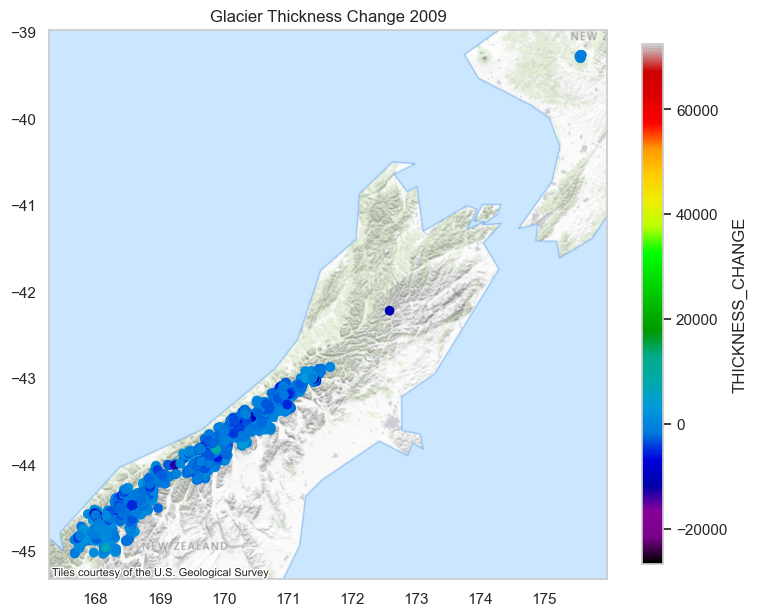

In [31]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2009.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2009")
# plt.grid()
# plt.show()

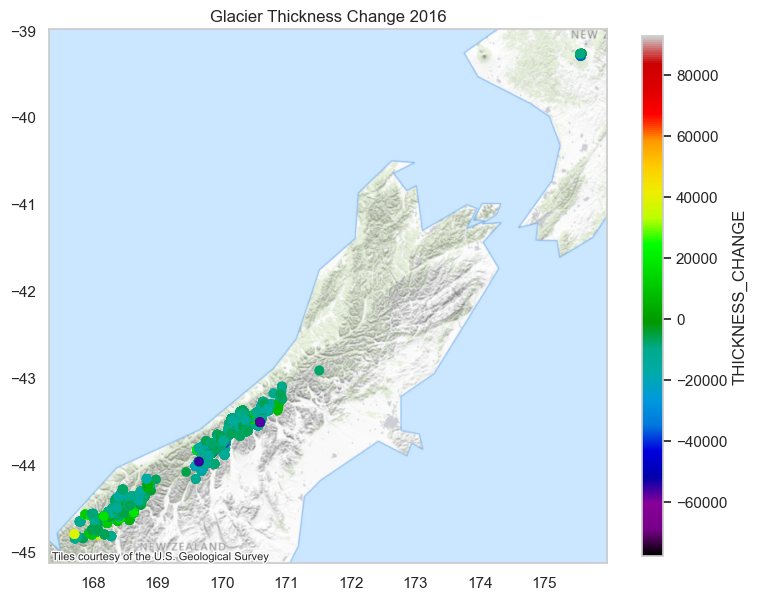

In [32]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2016.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2016")
# plt.grid()
# plt.show()

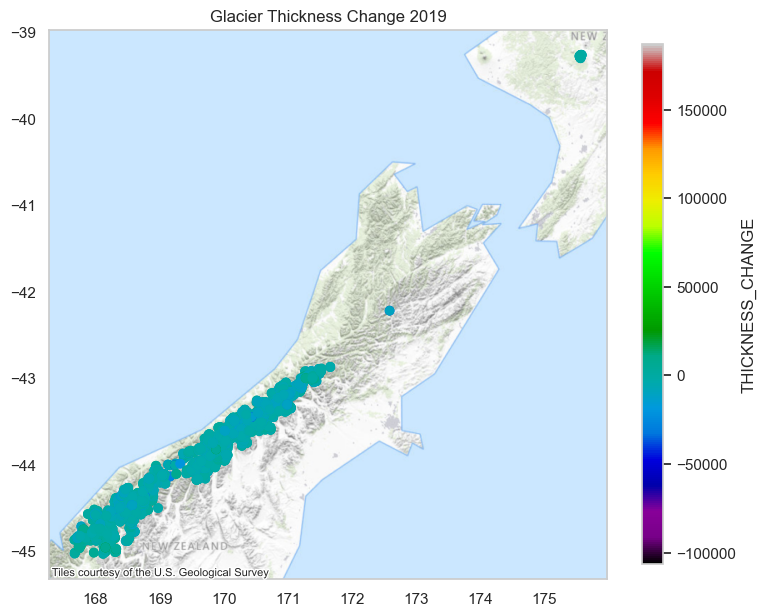

In [33]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2019.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2019")
# plt.grid()
# plt.show()

# Bird

In [34]:
bird_df = pd.read_csv("data_cleaned/bird_data.csv")

bird_gdf = gpd.GeoDataFrame(
    bird_df, 
    geometry=gpd.points_from_xy(bird_df.LONGITUDE, bird_df.LATITUDE), 
    crs="EPSG:4326"
)[["OBSERVATION DATE", "OBSERVATION COUNT", "geometry"]]

bird_gdf['year'] = bird_gdf["OBSERVATION DATE"].str[:4].astype(int)
bird_gdf.drop('OBSERVATION DATE', axis=1, inplace=True)

In [35]:
bird_gdf = bird_gdf[bird_gdf['year'].isin([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
bird_gdf['year'].value_counts()

year
2019    157
2018    135
2010    110
2009    107
2011     91
2016     77
2017     77
2012     73
2015     61
2014     46
2013     41
Name: count, dtype: int64

In [36]:
bird_gdf

,OBSERVATION COUNT,geometry,year
4,1.0,POINT (172.7 -42.111),2013
158,1.0,POINT (171.52 -42.914),2009
159,1.0,POINT (171.57 -42.928),2010
160,2.0,POINT (171.17 -43.091),2010
161,1.0,POINT (171.52 -42.914),2011
...,...,...,...
5013,2.0,POINT (171.53 -42.896),2014
5014,4.0,POINT (168.02 -44.756),2012
5015,1.0,POINT (168.02 -44.756),2014
5016,3.0,POINT (168.07 -44.731),2014


## Getis-Ord Gi* Hotspot

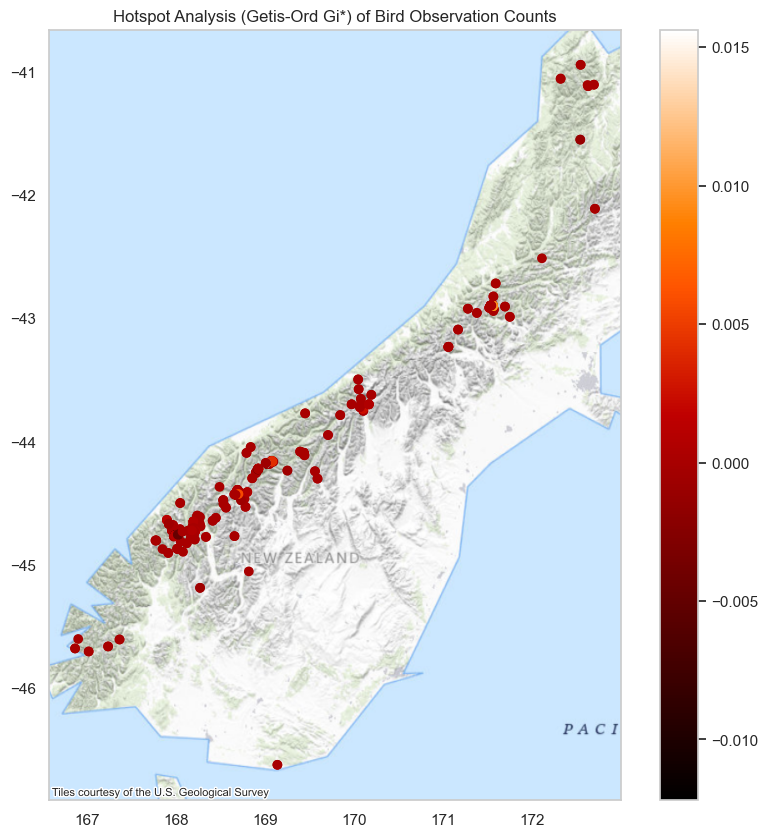

In [37]:
import geopandas as gpd
import numpy as np
from libpysal.weights import DistanceBand
from esda.getisord import G_Local
import matplotlib.pyplot as plt

# Extract the coordinates and variable for hotspot analysis
coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
observation_counts = bird_gdf['OBSERVATION COUNT']

w = DistanceBand(coords, threshold=50000, binary=True)

# Getis-Ord Gi* Hotspot analysis
g_local = G_Local(observation_counts, w)

bird_gdf['Gi*'] = g_local.Zs  # Gi* Z-scores
bird_gdf['p-value'] = g_local.p_sim  # p-value


# Visualise
fig, ax = plt.subplots(figsize=(10, 10))
bird_gdf.plot(column='Gi*', cmap='gist_heat', legend=True, ax=ax)

ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)

plt.title('Hotspot Analysis (Getis-Ord Gi*) of Bird Observation Counts')
plt.grid()
plt.show()

# Check spatial autocorrelation of bird

In [38]:
# Global Moran for bird_gdf
import geopandas as gpd
import numpy as np
import pysal.lib as ps
from esda.moran import Moran
from libpysal.weights import DistanceBand

observation_counts = bird_gdf['OBSERVATION COUNT']

coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
w = DistanceBand(coords, threshold=50000, binary=True)

moran = Moran(observation_counts, w)

print(f"Global Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")


Global Moran's I: -0.0015749108455458995
p-value: 0.099


# Analyse annual change

In [39]:
# Group bird_gdf by year and sum the observation counts
yearly_counts = bird_gdf.groupby('year')['OBSERVATION COUNT'].sum().reset_index()

# Rename columns for clarity
yearly_counts.columns = ['Year', 'Total Observation Count']

# Display the yearly total observation counts
yearly_counts

,Year,Total Observation Count
0,2009,167.0
1,2010,198.0
2,2011,165.0
3,2012,132.0
4,2013,83.0
5,2014,81.0
6,2015,150.0
7,2016,134.0
8,2017,163.0
9,2018,335.0


In [40]:
# Calculate the year-to-year change and percentage change in observation counts
yearly_counts['Change'] = yearly_counts['Total Observation Count'].diff()

# Calculate percentage change relative to the previous year
yearly_counts['Percentage Change'] = yearly_counts['Change'] / yearly_counts['Total Observation Count'].shift(1) * 100

# Display the yearly changes and percentage changes
yearly_counts

,Year,Total Observation Count,Change,Percentage Change
0,2009,167.0,NaN,NaN
1,2010,198.0,31.0,18.562874
2,2011,165.0,-33.0,-16.666667
3,2012,132.0,-33.0,-20.000000
4,2013,83.0,-49.0,-37.121212
5,2014,81.0,-2.0,-2.409639
6,2015,150.0,69.0,85.185185
7,2016,134.0,-16.0,-10.666667
8,2017,163.0,29.0,21.641791
9,2018,335.0,172.0,105.521472


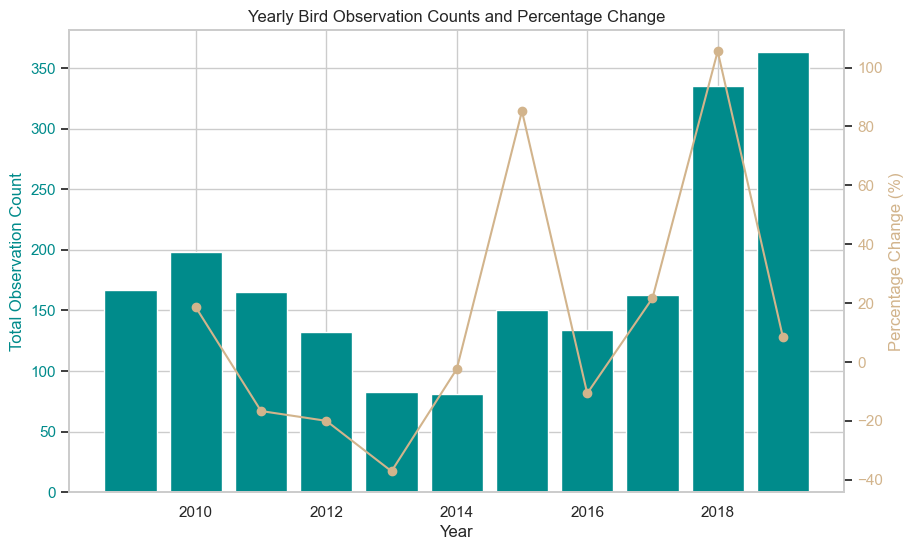

In [41]:
import matplotlib.pyplot as plt

# Plot the yearly observation counts and changes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total observation counts
ax1.bar(yearly_counts['Year'], yearly_counts['Total Observation Count'], color='darkcyan', label='Total Observation Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Observation Count', color='darkcyan')
ax1.tick_params(axis='y', labelcolor='darkcyan')

# Create a second y-axis to plot the percentage change
ax2 = ax1.twinx()
ax2.plot(yearly_counts['Year'], yearly_counts['Percentage Change'], color='tan', label='Percentage Change', marker='o')
ax2.set_ylabel('Percentage Change (%)', color='tan')
ax2.tick_params(axis='y', labelcolor='tan')

# Add a title and show the plot
plt.title('Yearly Bird Observation Counts and Percentage Change')
plt.grid(False)
plt.show()

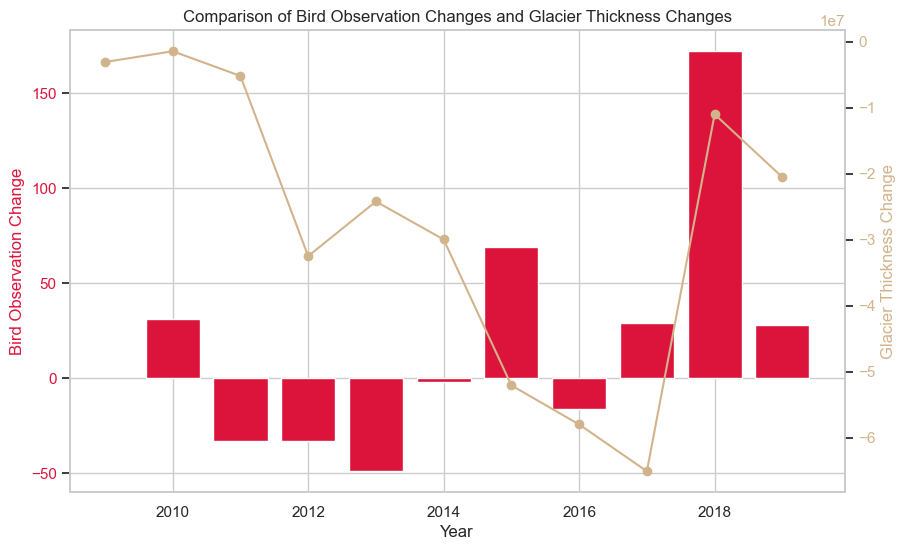

In [42]:
# Assuming you have a dataframe gdf_wgms with glacier thickness changes per year
# Group glacier data by year and sum the thickness changes

yearly_glacier_change = gdf_wgms.groupby('CHANGE_YEAR')['THICKNESS_CHANGE'].sum().reset_index()

# Rename columns for clarity
yearly_glacier_change.columns = ['Year', 'Total Thickness Change']

# Merge the two datasets on the Year column to compare bird observation and glacier changes
comparison_df = pd.merge(yearly_counts, yearly_glacier_change, on='Year', how='inner')

# Plot the comparison of bird observation changes and glacier thickness changes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bird observation changes
ax1.bar(comparison_df['Year'], comparison_df['Change'], color='crimson', label='Bird Observation Change')
ax1.set_xlabel('Year')
ax1.set_ylabel('Bird Observation Change', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Create a second y-axis to plot glacier thickness changes
ax2 = ax1.twinx()
ax2.plot(comparison_df['Year'], comparison_df['Total Thickness Change'], color='tan', label='Glacier Thickness Change', marker='o')
ax2.set_ylabel('Glacier Thickness Change', color='tan')
ax2.tick_params(axis='y', labelcolor='tan')

# Add a title and show the plot
plt.title('Comparison of Bird Observation Changes and Glacier Thickness Changes')
plt.grid(False)
plt.show()


## Check spatial points visually

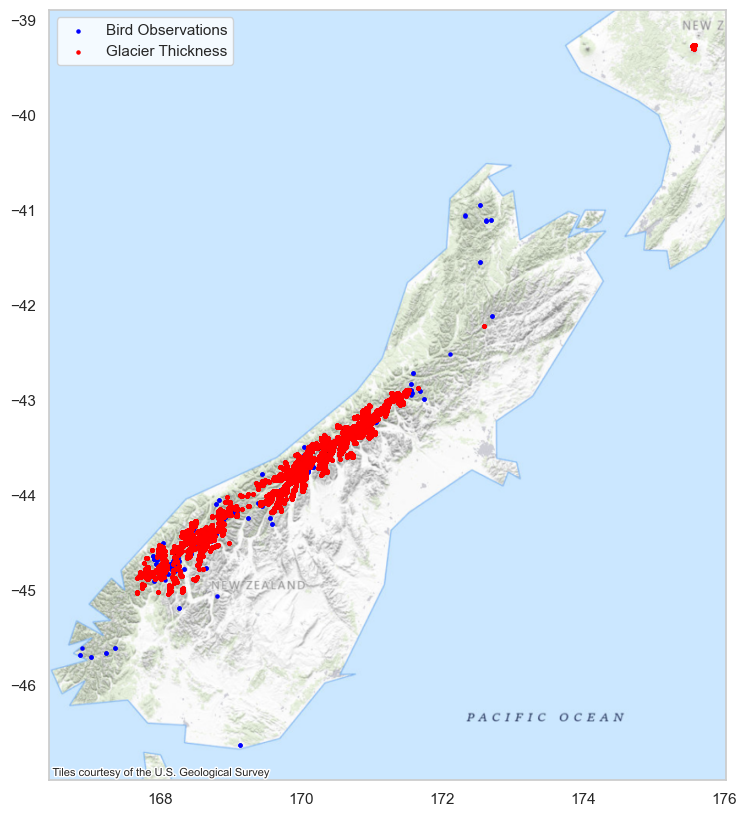

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

bird_gdf.plot(ax=ax, color='blue', label='Bird Observations', markersize=5)
gdf_wgms.plot(ax=ax, color='red', label='Glacier Thickness', markersize=5)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
plt.legend()
plt.grid()
plt.show()

# Nearby connect glacier and bird based on distance

In [44]:
from scipy.spatial import cKDTree

# Step 1: Extract coordinates of both datasets
bird_coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
glacier_coords = np.array(list(zip(gdf_wgms.geometry.x, gdf_wgms.geometry.y)))

# Step 2: Build a KDTree for the glacier points
tree = cKDTree(glacier_coords)

# Step 3: Query the tree for the nearest glacier point for each bird observation
distances, indices = tree.query(bird_coords, k=1)

# Step 4: Add nearest glacier data to bird_gdf
bird_gdf['Nearest Glacier ID'] = gdf_wgms.iloc[indices]['WGMS_ID'].values
bird_gdf['Nearest Glacier Thickness Change'] = gdf_wgms.iloc[indices]['THICKNESS_CHANGE'].values
bird_gdf['Distance to Glacier'] = distances

# Step 5: Inspect the result
bird_gdf.head()

,OBSERVATION COUNT,geometry,year,Gi*,p-value,Nearest Glacier ID,Nearest Glacier Thickness Change,Distance to Glacier
4,1.0,POINT (172.7 -42.111),2013,6.837417e-15,0.001,144044,-9275.0,0.159697
158,1.0,POINT (171.52 -42.914),2009,1.247343e-03,0.001,145908,-5780.0,0.004018
159,1.0,POINT (171.57 -42.928),2010,6.837417e-15,0.001,145907,-13860.0,0.049040
160,2.0,POINT (171.17 -43.091),2010,6.326536e-15,0.001,21932,-11396.0,0.013470
161,1.0,POINT (171.52 -42.914),2011,1.247343e-03,0.001,145908,-5780.0,0.004018


# Global Bivariate Moran's I

In [45]:
from esda.moran import Moran_BV
from libpysal.weights import DistanceBand

# Step 1: Extract the coordinates of the bird observation points
coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))

# Step 2: Create the spatial weights matrix (based on distances between bird observation points)
w = DistanceBand(coords, threshold=50000, binary=True)

# Step 3: Extract the two variables for Bivariate Moran's I
# Variable 1: Bird observation counts
observation_change = bird_gdf['OBSERVATION COUNT']

# Variable 2: Nearest glacier thickness change
thickness_change = bird_gdf['Nearest Glacier Thickness Change']

# Step 4: Perform Bivariate Moran's I calculation
moran_bv = Moran_BV(observation_change, thickness_change, w)

# Step 5: Print results
print(f"Bivariate Moran's I: {moran_bv.I}")
print(f"p-value: {moran_bv.p_sim}")


Bivariate Moran's I: -0.0001247611840395598
p-value: 0.147


# Moran's Scatter Plot

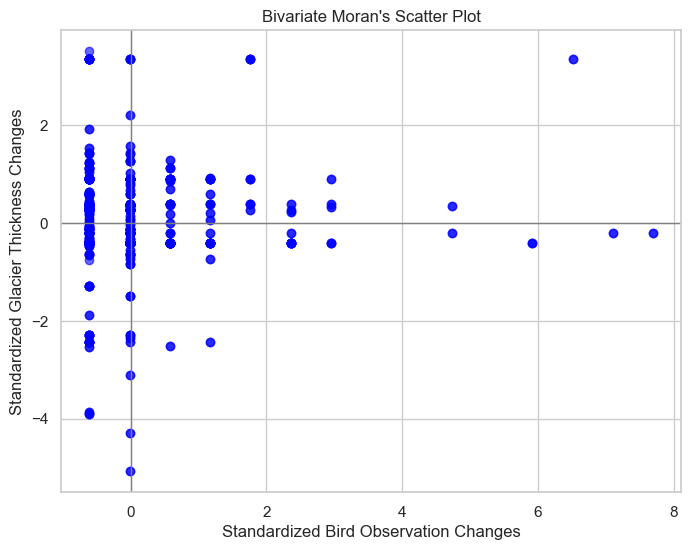

In [46]:
import matplotlib.pyplot as plt

# Step 1: Extract the standardized values of the two variables
observation_change = bird_gdf['OBSERVATION COUNT']
thickness_change = bird_gdf['Nearest Glacier Thickness Change']

# Standardize the two variables (Z-scores)
observation_z = (observation_change - observation_change.mean()) / observation_change.std()
thickness_z = (thickness_change - thickness_change.mean()) / thickness_change.std()

# Step 2: Plot the Moran's Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(observation_z, thickness_z, alpha=0.6, c='blue')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Bivariate Moran's Scatter Plot")
plt.xlabel('Standardized Bird Observation Changes')
plt.ylabel('Standardized Glacier Thickness Changes')
plt.show()


# Local Bivariate Moran's I

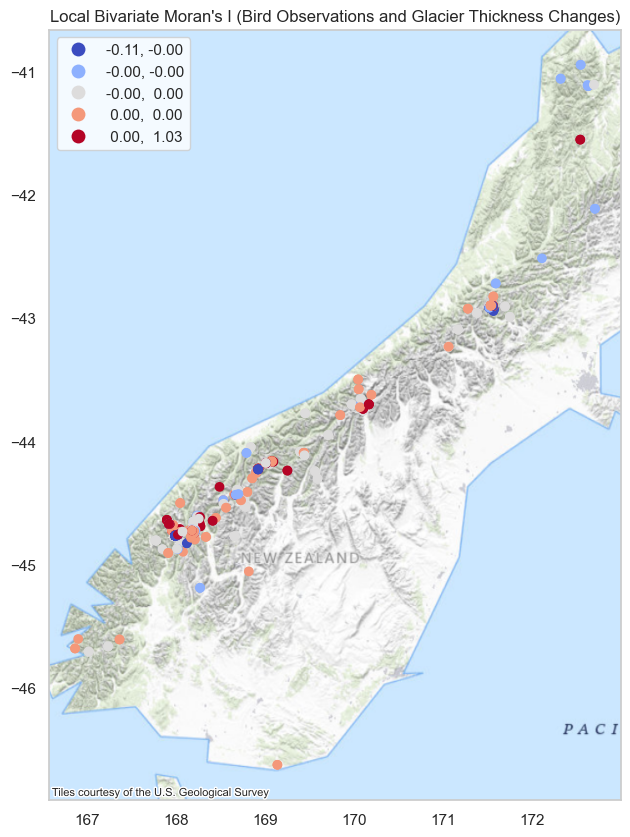

In [48]:
from esda.moran import Moran_Local_BV
import matplotlib.pyplot as plt
import geopandas as gpd
from libpysal.weights import DistanceBand

# Step 1: Extract the coordinates and create spatial weights matrix
coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
w = DistanceBand(coords, threshold=50000, binary=True)

# Step 2: Perform Local Bivariate Moran's I
observation_change = bird_gdf['OBSERVATION COUNT']
thickness_change = bird_gdf['Nearest Glacier Thickness Change']

local_bv = Moran_Local_BV(observation_change, thickness_change, w)

# Step 3: Add the results to the original GeoDataFrame for visualization
bird_gdf['Local Bivariate Moran'] = local_bv.Is
bird_gdf['p-value'] = local_bv.p_sim

# Step 4: Plot the Local Bivariate Moran's I values
fig, ax = plt.subplots(figsize=(10, 10))
bird_gdf.plot(column='Local Bivariate Moran', cmap='coolwarm', scheme='quantiles', legend=True, ax=ax)
plt.title("Local Bivariate Moran's I (Bird Observations and Glacier Thickness Changes)")
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
plt.grid()
plt.show()
